<a href="https://colab.research.google.com/github/Aleksey128/Numpy_solutions.ipynb/blob/main/%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%9B%D0%B0%D1%81%D1%81%D0%BE_%D0%B8_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Цели и задачи

**Цели**:

Проанализировать взаимосвязь между экономическими и политическими факторами и ВВП на душу населения, используя данные Индекса экономической свободы 2019 года.

Создать информативные визуализации с использованием Matplotlib и Geopandas для выделения взаимосвязей между различными факторами и экономическими показателями.

Построить прогностические модели с использованием Lasso и PCA для лучшего понимания того, как компоненты экономической свободы влияют на ВВП на душу населения.

**Задачи**:

Предварительно обработать данные, чтобы удалить всю недостающую или неактуальную информацию и убедиться, что данные готовы к анализу.

Визуализировать данные с помощью Matplotlib и Geopandas, чтобы выявить любые тенденции или взаимосвязи между различными экономическими и политическими факторами и ВВП на душу населения.

Использовать Lasso и PCA для создания прогностических моделей для ВВП на душу населения на основе компонентов экономической свободы.

Сравнить эффективность моделей Lasso и PCA с простой моделью, использующей общий балл свободы, присвоенный индексом, чтобы получить представление о взаимосвязи между компонентами и ВВП на душу населения.

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
import geopandas

In [ ]:
df = pd.read_csv('economic_freedom_index2019_data.csv', encoding='ISO-8859-1')
df.columns

Index(['CountryID', 'Country Name', 'WEBNAME', 'Region', 'World Rank',
       'Region Rank', '2019 Score', 'Property Rights', 'Judical Effectiveness',
       'Government Integrity', 'Tax Burden', 'Gov't Spending', 'Fiscal Health',
       'Business Freedom', 'Labor Freedom', 'Monetary Freedom',
       'Trade Freedom', 'Investment Freedom ', 'Financial Freedom',
       'Tariff Rate (%)', 'Income Tax Rate (%)', 'Corporate Tax Rate (%)',
       'Tax Burden % of GDP', 'Gov't Expenditure % of GDP ', 'Country',
       'Population (Millions)', 'GDP (Billions, PPP)', 'GDP Growth Rate (%)',
       '5 Year GDP Growth Rate (%)', 'GDP per Capita (PPP)',
       'Unemployment (%)', 'Inflation (%)', 'FDI Inflow (Millions)',
       'Public Debt (% of GDP)'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CountryID                    186 non-null    int64  
 1   Country Name                 186 non-null    object 
 2   WEBNAME                      186 non-null    object 
 3   Region                       186 non-null    object 
 4   World Rank                   180 non-null    float64
 5   Region Rank                  180 non-null    float64
 6   2019 Score                   180 non-null    float64
 7   Property Rights              185 non-null    float64
 8   Judical Effectiveness        185 non-null    float64
 9   Government Integrity         185 non-null    float64
 10  Tax Burden                   180 non-null    float64
 11  Gov't Spending               183 non-null    float64
 12  Fiscal Health                183 non-null    float64
 13  Business Freedom    

<Axes: >

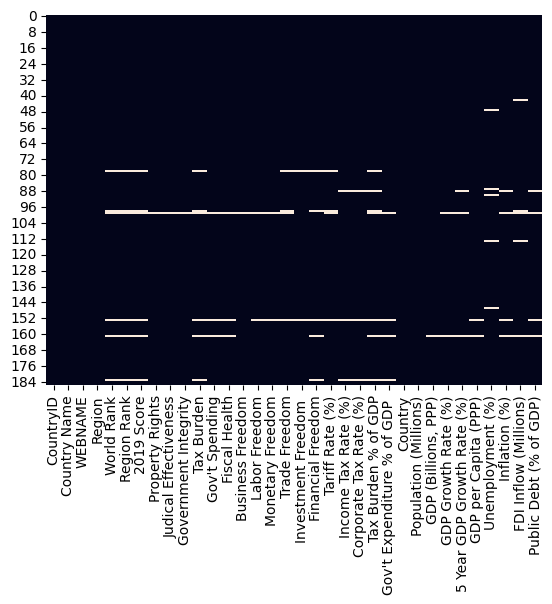

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

На тепловой карте видны отсутствующие значения в DataFrame

<Axes: >

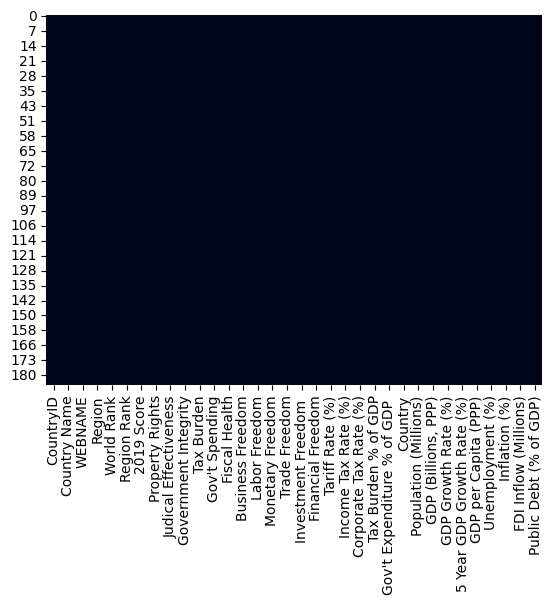

In [ ]:
df = df.dropna(axis=0)
sns.heatmap(df.isnull(), cbar=False)

Удаляем все строки из данных df, содержащие пропущенные значения, а затем строим тепловую карту, что бы убедится в этом наглядно

In [ ]:
columnsToChange = ['FDI Inflow (Millions)', 'GDP per Capita (PPP)', 'GDP (Billions, PPP)', 'Unemployment (%)', 'Population (Millions)']
for column in columnsToChange:
  data = df[column]
  edited = []
  for row in data:
    noComma = row.replace(',', '')
    noDolar = noComma.replace('$', '')
    edited.append(noDolar)
  df[column] = [x for x in edited]
  df[column] = df[column].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 0 to 185
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CountryID                    173 non-null    int64  
 1   Country Name                 173 non-null    object 
 2   WEBNAME                      173 non-null    object 
 3   Region                       173 non-null    object 
 4   World Rank                   173 non-null    float64
 5   Region Rank                  173 non-null    float64
 6   2019 Score                   173 non-null    float64
 7   Property Rights              173 non-null    float64
 8   Judical Effectiveness        173 non-null    float64
 9   Government Integrity         173 non-null    float64
 10  Tax Burden                   173 non-null    float64
 11  Gov't Spending               173 non-null    float64
 12  Fiscal Health                173 non-null    float64
 13  Business Freedom    

Далее модифицируем выбранные столбцы в DataFrame, удаляя запятые и знаки доллара из значений, преобразуя тип данных этих столбцов к float, а затем выводим информацию о DataFrame.

In [ ]:
# the twelve components of economic freedom
RANKS = ['Property Rights', 'Government Integrity', 'Tax Burden', 'Fiscal Health', 'Business Freedom','Labor Freedom', 'Monetary Freedom', 'Trade Freedom', 'Financial Freedom']

# earlier list plus 2019 score column
RANKS_PLUS_TOTAL = ['2019 Score'] + RANKS

# columns with other statistics for each country calculated as a percentage
PERCENTAGE_STATS = ['Tariff Rate (%)', 'Income Tax Rate (%)', 'Corporate Tax Rate (%)', 
                     'Tax Burden % of GDP', 'Gov Expenditure % of GDP', 'GDP Growth Rate (%)', '5 Year GDP Growth Rate (%)',
                     'Unemployment (%)', 'Inflation (%)', 'Public Debt (% of GDP)', 'GDP per Capita (PPP)']

Определим три списка, которые используются для организации и группировки столбцов в DataFrame.

# Анализ данных

Ниже создадим две функции.

Функция classif создает схему классификации для присвоения цветов графикам. Значения разделены на шесть диапазонов, каждый из которых имеет свой цвет, начиная от "темно-зеленого" для оценок выше 80 и заканчивая "красным" для оценок ниже 40.

Функция boxPlots создает боксплот для каждого столбца входного массива данных с помощью matplotlib. Затем она вычисляет медиану для каждого столбца и присваивает цвет боксплоту на основе медианного балла с помощью функции classif. Наконец, он устанавливает цвета ячеек и медианных линий в блок-схеме с помощью метода set_facecolor объекта patch.

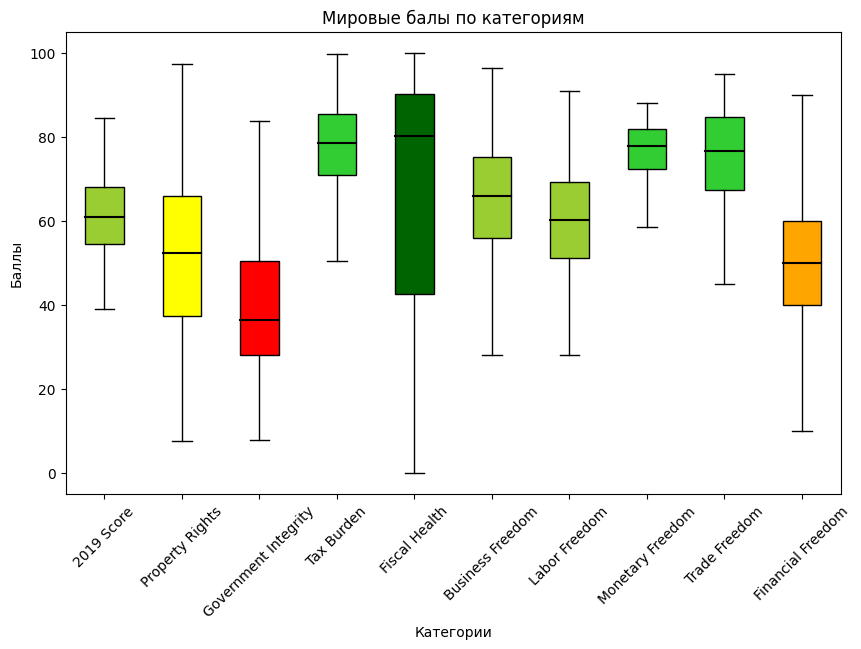

In [ ]:
def classif(item):
  if item > 80:
    return 'darkgreen'
  elif item > 70:
    return 'limegreen'
  elif item > 60:
    return 'yellowgreen'
  elif item > 50:
    return 'yellow'
  elif item > 40:
    return 'orange'  
  else: 
    return 'red'

# function for making boxplots
def boxPlots(df):
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))
  lst = [df[column] for column in df.columns]
  medianPropDict = dict(color='black', linewidth=1.5)
  bplot = ax.boxplot(lst, vert=True, showfliers=False, positions=range(1, len(df.columns)+1), patch_artist=True, medianprops=medianPropDict)
  ax.set_xticks(range(1, len(df.columns)+1))
  ax.set_xticklabels(df.columns, rotation=45)
  ax.set_xlabel("Категории")
  ax.set_ylabel("Баллы")
  ax.set_title('Мировые балы по категориям')
  
  colors = []
  for column in df.columns:
    data = df[column]
    median = data.median()
    colors.append(classif(median))
  
  for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

boxPlots(df[RANKS_PLUS_TOTAL])

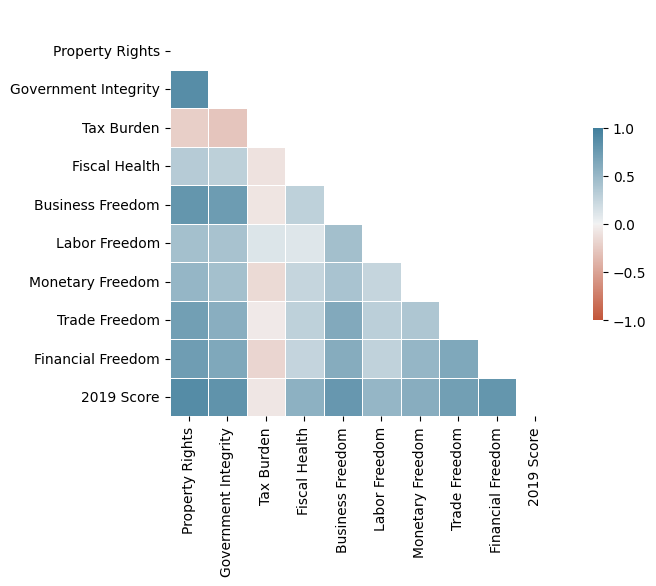

In [ ]:
def corrMatrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(10, 5))
  cmap = sns.diverging_palette(20, 230, as_cmap=True)
  sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, vmin = -1, center = 0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  plt.title(' ')

corrMatrix(df[RANKS + ['2019 Score']])

Из графика можно сделать вывод о наличии сильной положительной корреляции между большинством переменных в корреляционной матрице, за исключением переменной "Налоговое бремя" (Tax Burden), которая имеет отрицательную корреляцию со всеми остальными переменными. Это говорит о том, что страны с более высокими показателями в таких областях, как права собственности, целостность правительства, фискальное здоровье, свобода бизнеса, свобода труда, денежная свобода, свобода торговли и финансовая свобода, как правило, имеют более высокие общие показатели в оценке 2019 года.

Однако отрицательная корреляция переменной "Налоговое бремя" с другими переменными предполагает, что страны с более низким налоговым бременем, как правило, имеют более высокие показатели в других областях. Важно отметить, что это корреляция, а не обязательно причинно-следственная связь, и на эти взаимосвязи могут влиять и другие факторы.

In [ ]:
df.rename(columns={'Country Name': 'CountryName', 
                   'Judical Effectiveness': 'Judicial Effectiveness', 
                   'Gov\'t Spending': 'Gov Spending', 
                   'Gov\'t Expenditure % of GDP ': 'Gov Expenditure % of GDP',
                    'Investment Freedom ': 'Investment Freedom'}, inplace=True)

Создадим функцию которая извлекает данные по указанной стране и строит гистограмму со средними баллами по категориям и общий средний балл для страны


In [ ]:
def countryDashbord (countryName):
  countryData = df.loc[df.CountryName == countryName]


  fig = plt.figure(constrained_layout=True, figsize=(10, 8))
  gs = fig.add_gridspec(ncols=9, nrows=3)

  f_ax1 = fig.add_subplot(gs[:-1, 1:])
  string = countryName + ' cредние баллы и баллы по категориям'
  f_ax1.set_title(string, fontsize=16)
  data = countryData[RANKS]
  for idx, column in enumerate(data.columns):
    point = data[column].iloc[0]
    color = classif(point)
    plt.bar(idx, height=point, color=color, width=0.7)
    plt.text(idx-0.25, point+2,point, fontsize=14)
  numColumns = range(len(data.columns))


  f_ax1.set_yticks(range(0, 110, 10))
  f_ax1.set_yticklabels([])
  f_ax1.set_xticks(numColumns)
  f_ax1.set_xticklabels(data.columns, rotation=45)
  

  f_ax2 = fig.add_subplot(gs[:-1, 0])
  totalScore = countryData['2019 Score'].iloc[0]
  color = classif(totalScore)
  f_ax2.set_ylabel("Баллы")
  f_ax2.bar(1, height=totalScore, color=color, width=1.5)
  f_ax2.text(1-0.25, totalScore+2, totalScore, fontsize=15)
  f_ax2.set_xticks([1])
  f_ax2.set_xticklabels(["Средний балл"], rotation=45)
  f_ax2.set_yticks(range(0, 110, 10))
  f_ax2.set_yticklabels(range(0, 110, 10))

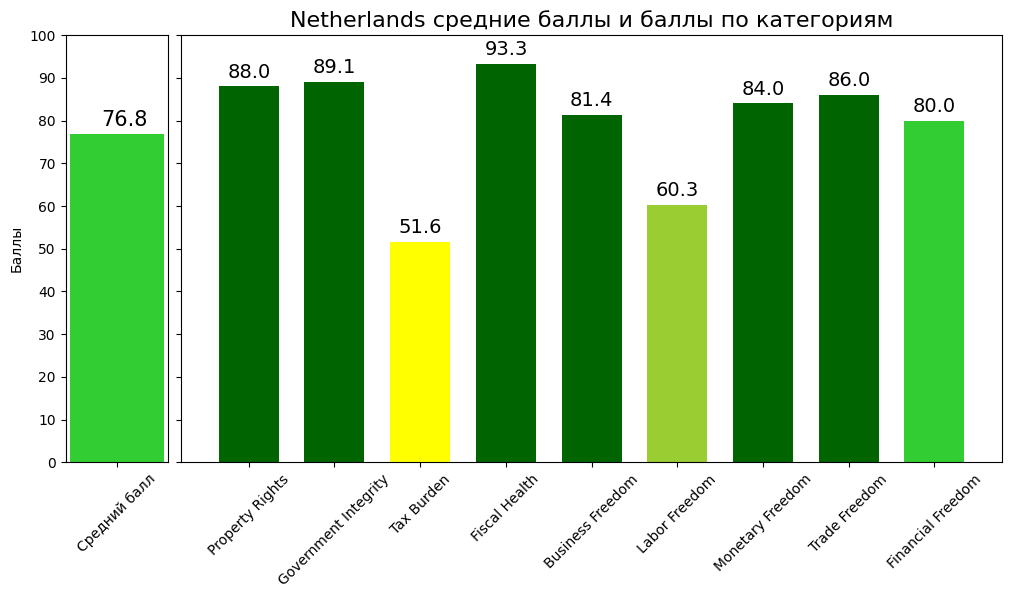

In [ ]:
countryDashbord('Netherlands')

# Карта мира

Ниже представлен ряд графиков на которых можно увидеть мировую карту, где каждая страны окрашена в соответствующий цвет, отражающий их оценку в заданной категории ("2019 Score"). Это позволяет визуально сравнить оценки различных стран в выбранной категории и их распределение по географическим регионам.

<ipython-input-26-c258183346e9>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


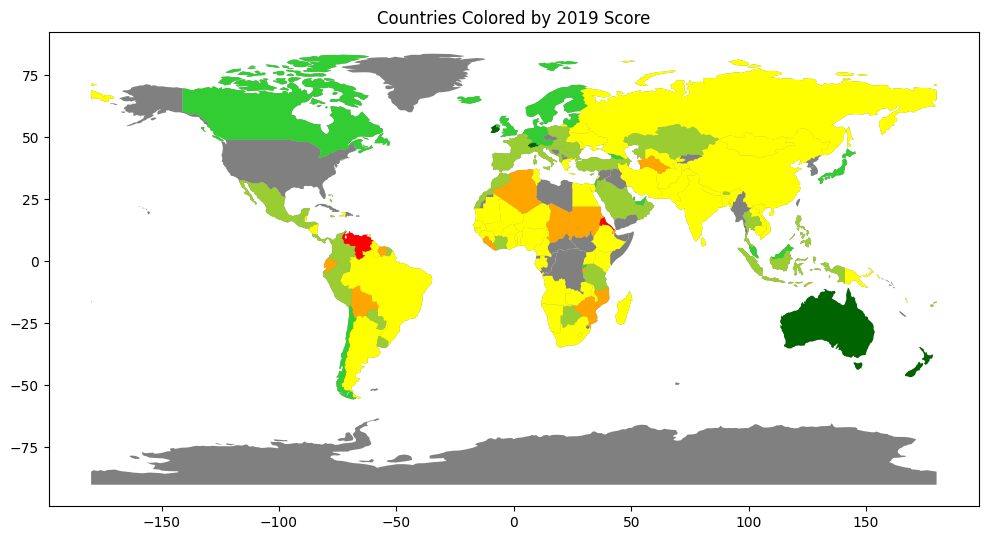

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
def worldMapView(worldDf, category):
    
    ax = world.plot(figsize=(12, 10), color="gray")
    for i, row in df.iterrows():
        countryName = row["CountryName"]
        score = row[category]
        
        row = world[world["name"] == countryName]
        if row.empty:
            continue
        row.plot(color=classif(score),ax=ax)

    plt.title("Countries Colored by " + category)
    plt.show()

worldMapView(world, "2019 Score")

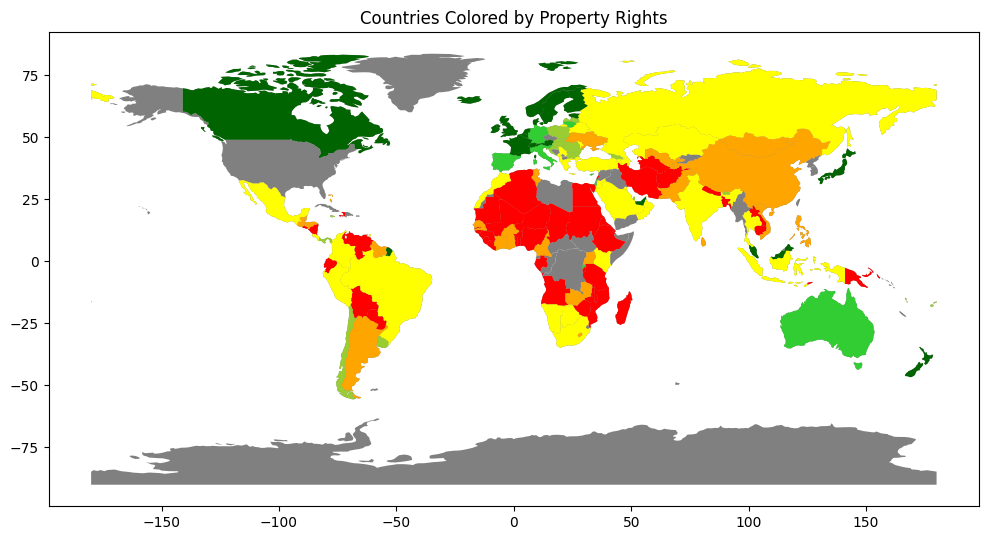

In [ ]:
worldMapView(world, "Property Rights")

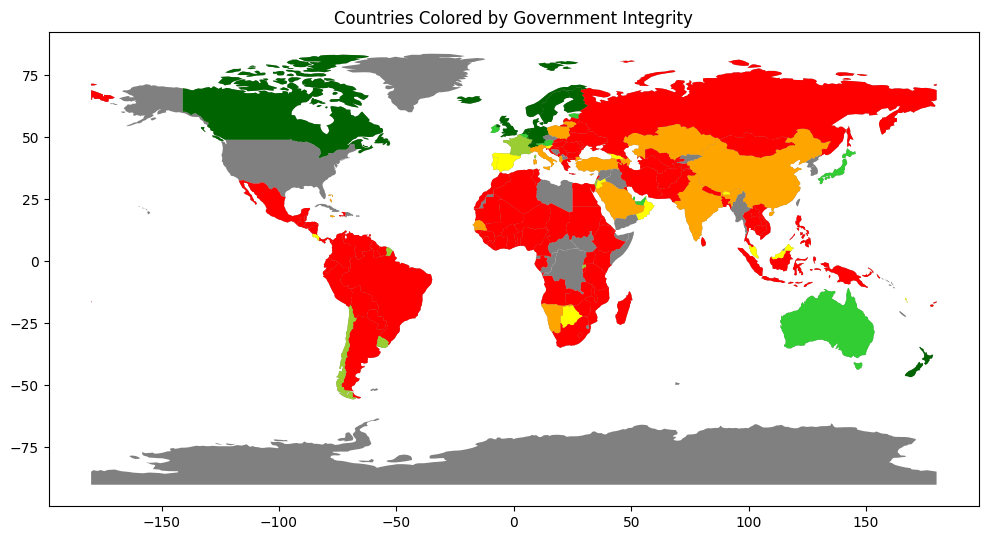

In [ ]:
worldMapView(world, "Government Integrity")

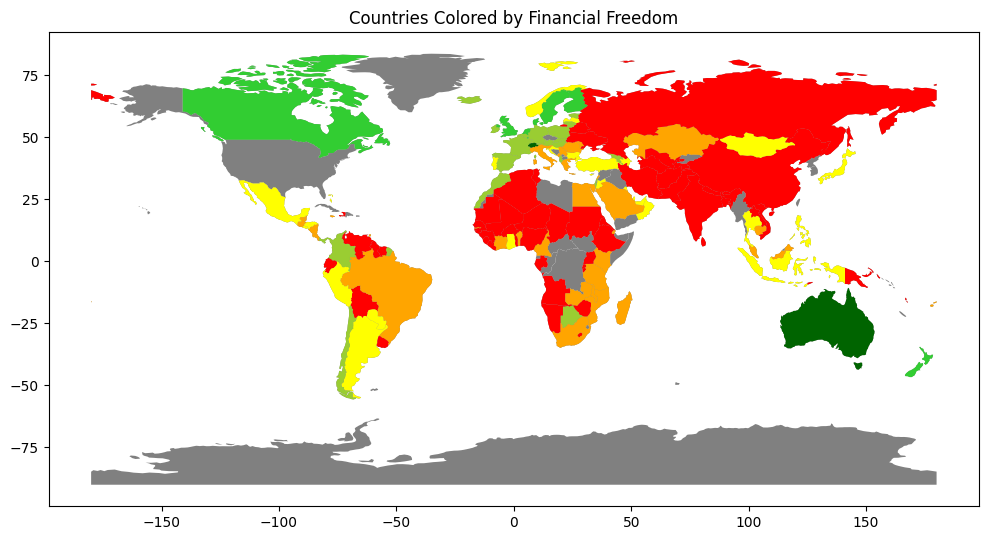

In [ ]:
worldMapView(world, "Financial Freedom")

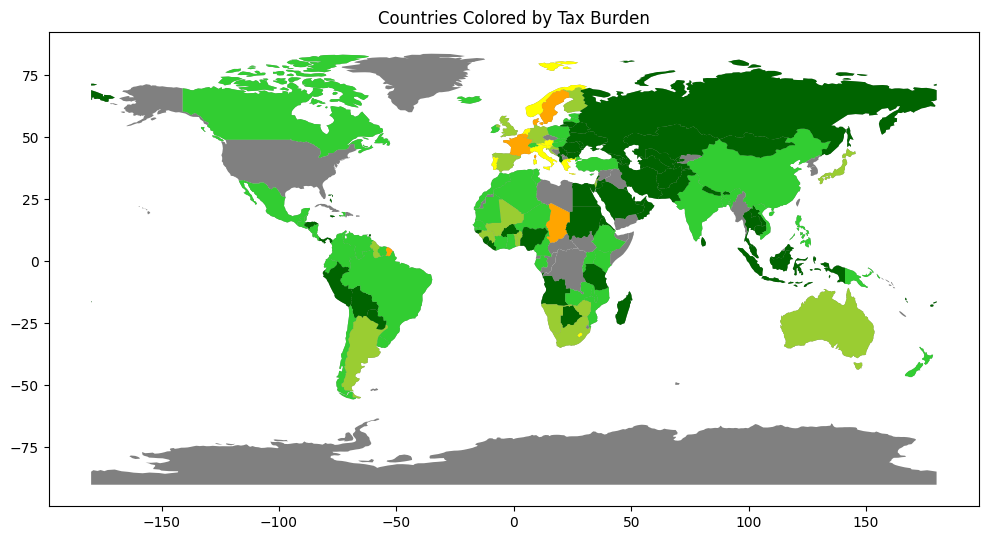

In [ ]:
worldMapView(world, "Tax Burden")

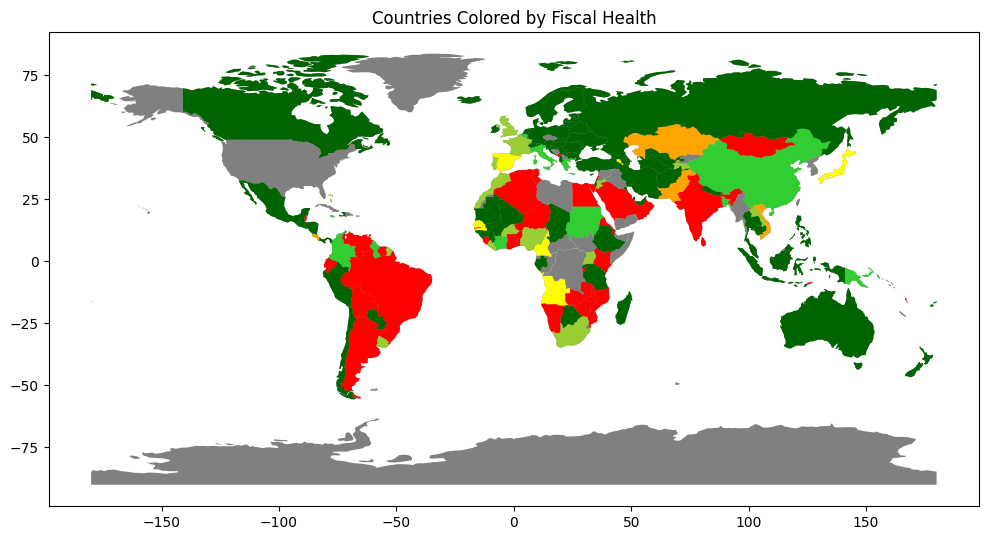

In [ ]:
worldMapView(world, "Fiscal Health")

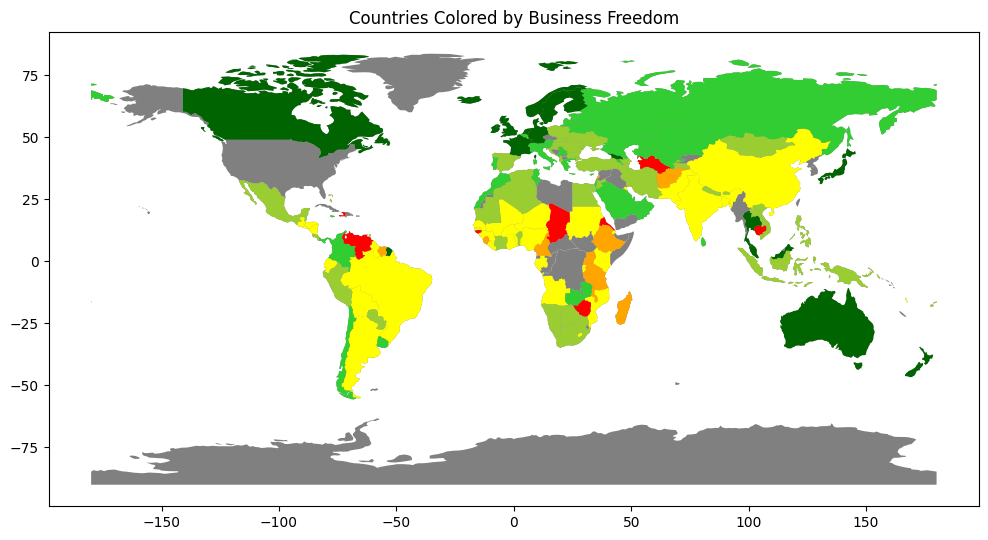

In [ ]:
worldMapView(world, "Business Freedom")

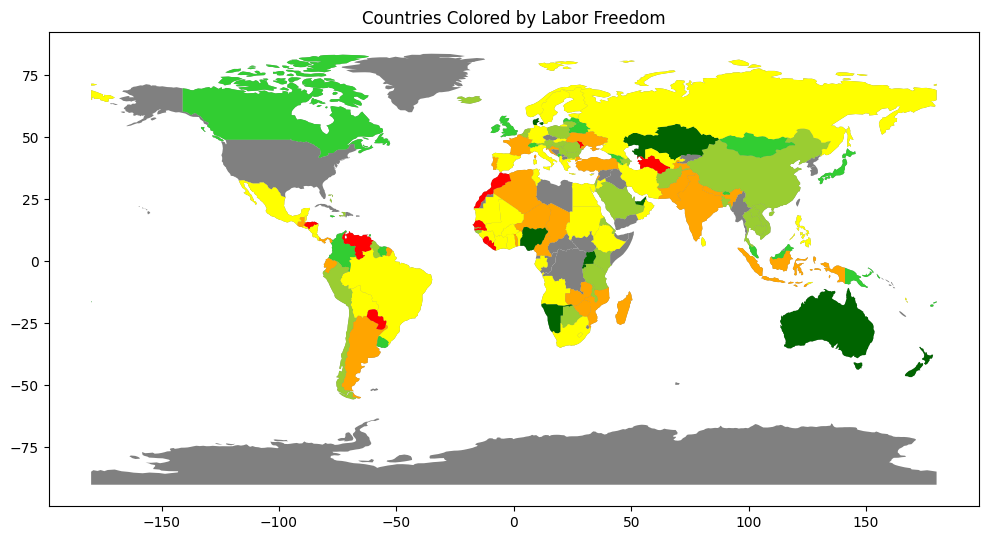

In [ ]:
worldMapView(world, "Labor Freedom")

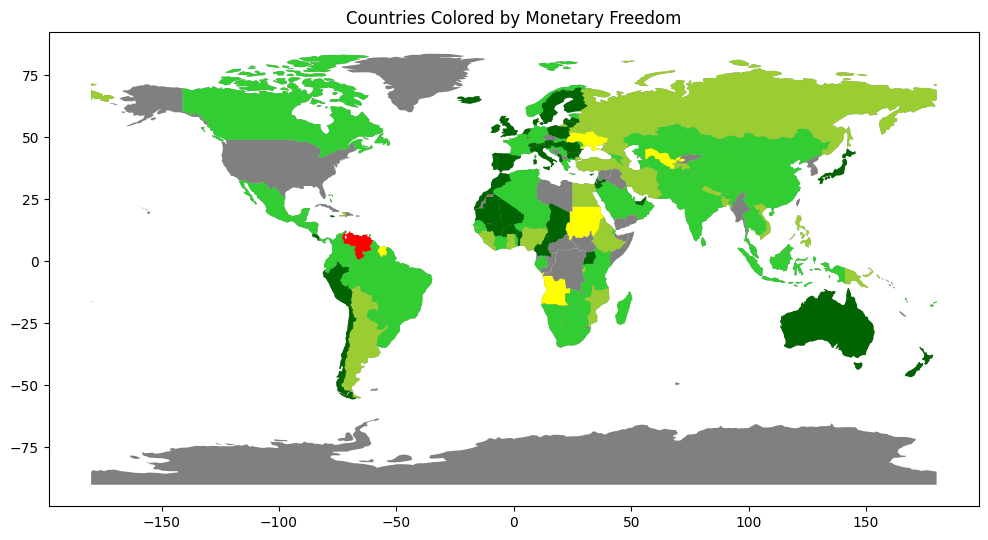

In [ ]:
worldMapView(world, "Monetary Freedom")

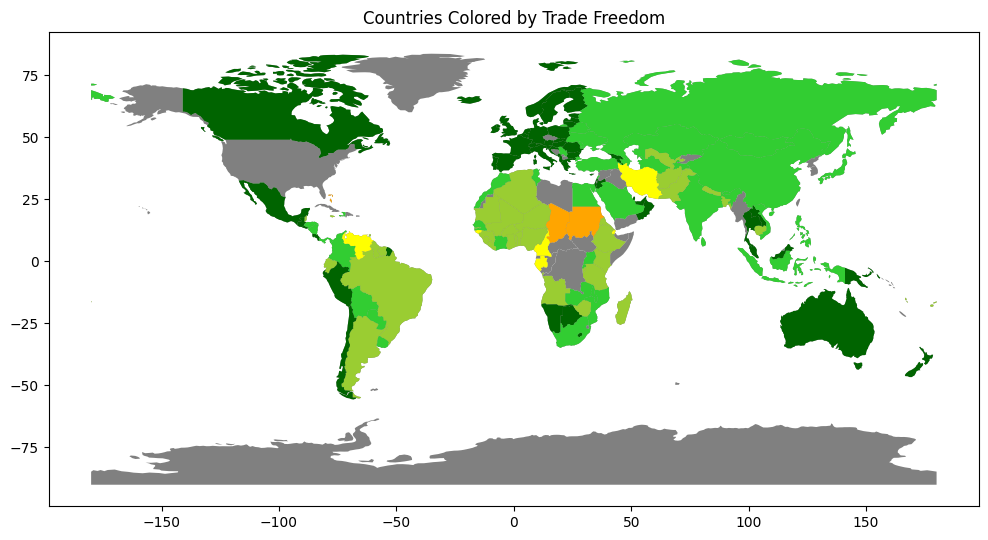

In [ ]:
worldMapView(world, "Trade Freedom")

#Модель, использующая общий балл свободы

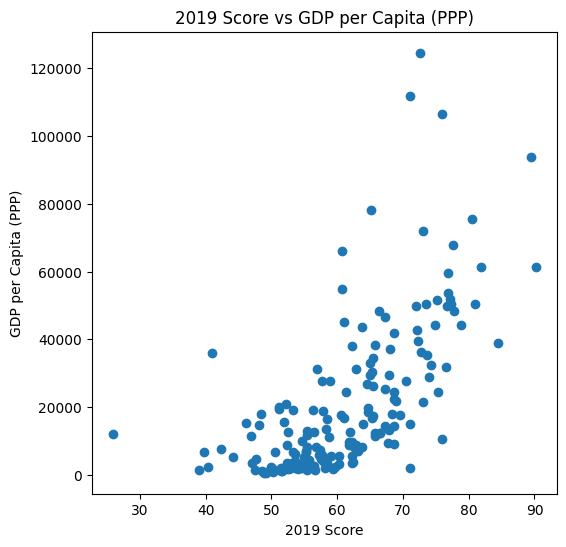

In [ ]:
df = df.sort_values(by="2019 Score")


def scatterPlot(X, Y, predictions=None):
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(X, Y)
    ax.set_title(X.name + " vs " + Y.name)
    ax.set_ylabel(Y.name)
    ax.set_xlabel(X.name)
    
    if predictions is not None:
        ax.plot(X, predictions, color="black")

    plt.show()

X_total = df["2019 Score"].reset_index(drop=True)
Y = df["GDP per Capita (PPP)"].reset_index(drop=True)

scatterPlot(X_total, Y);

 Положительная тенденция на диаграмме рассеяния указывает на положительную корреляцию между переменными "2019 Score" и "GDP per Capita (PPP)"

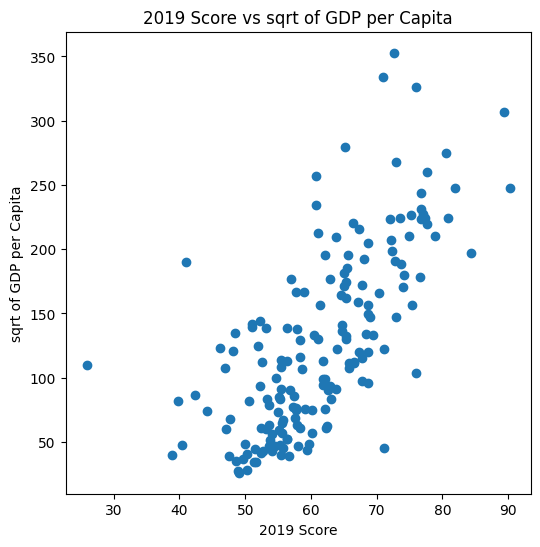

In [ ]:
Y = Y ** 0.5
Y.name = "sqrt of GDP per Capita"

scatterPlot(X_total, Y)

На диаграмме также видна положительная тенденция, которая указывает на положительную корреляцию между переменными. А преобразование переменной "GDP per Capita (PPP)" в квадратный корень помогает уменьшить влияние выбросов, обеспечивая более четкое понимание корреляции

In [ ]:
X_total = sm.add_constant(X_total)
model = sm.OLS(Y, X_total).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     sqrt of GDP per Capita   R-squared:                       0.476
Model:                                OLS   Adj. R-squared:                  0.473
Method:                     Least Squares   F-statistic:                     155.1
Date:                    Mon, 15 May 2023   Prob (F-statistic):           9.35e-26
Time:                            05:26:47   Log-Likelihood:                -927.34
No. Observations:                     173   AIC:                             1859.
Df Residuals:                         171   BIC:                             1865.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

В целом, регрессионный анализ показывает, что переменная "2019 Score" является значимым предиктором квадратного корня из "GDP per Capita (PPP)". Модель объясняет примерно 47,6% изменчивости переменной ответа, а коэффициенты дают представление о взаимосвязи между предикторами и ответом.

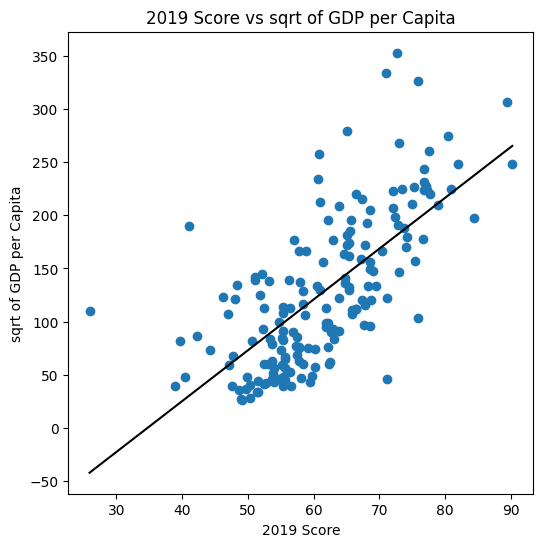

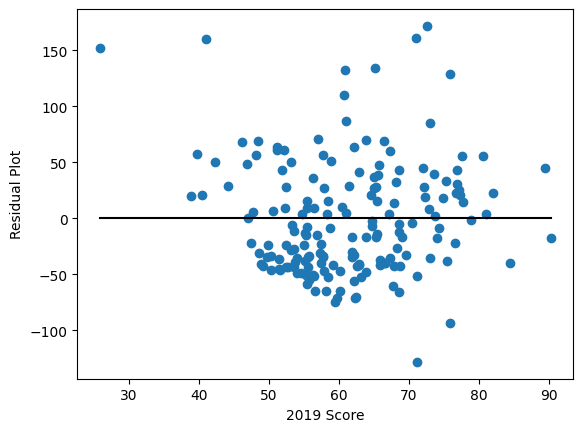

In [ ]:
predictions = model.predict(X_total)
scatterPlot(X_total['2019 Score'], Y, predictions)

residuals = Y - predictions
f, ax = plt.subplots()
ax.scatter(X_total['2019 Score'], residuals)
ax.set_xlabel('2019 Score')
ax.set_ylabel('Residual Plot')
ax.plot(X_total['2019 Score'], np.zeros(len(Y)), color='black')

plt.show()

Диаграмма рассеяния (первый график) показывает, что между этими двумя переменными существует положительная линейная зависимость. По мере увеличения "2019 Score" увеличивается и "ВВП на душу населения". Линия прогноза так же показывает общую тенденцию к росту.

Второй график это график остатков. Остатки - это разница между фактическими значениями "ВВП на душу населения" и прогнозируемыми значениями. График остатков показывает, что в остатках нет явной закономерности. Остатки беспорядочно разбросаны вокруг нулевой линии, что говорит о том, что модель машинного обучения не имеет систематического смещения. Это означает, что прогнозы модели не являются систематически завышенными или заниженными значениями "ВВП на душу населения" для какого-либо конкретного диапазона значений "2019 Score". В целом, график остатков показывает, что модель машинного обучения подходит для данных.

# Модель Lasso и PCA

In [ ]:
X_factors = df[RANKS].reset_index(drop=True)

correlationWithY = X_factors.corrwith(Y)
print(correlationWithY)

Property Rights         0.757953
Government Integrity    0.723849
Tax Burden             -0.103818
Fiscal Health           0.246569
Business Freedom        0.636753
Labor Freedom           0.284945
Monetary Freedom        0.349237
Trade Freedom           0.621179
Financial Freedom       0.641072
dtype: float64


Результат показывает коэффициенты корреляции между каждой переменной в X_factors и Y. Например, самый высокий коэффициент корреляции 0,757953 - между Property Rights и Y(ВВП на душу населения). Это говорит о том, что страна с сильной защитой прав собственности имеет тенденцию иметь более высокий ВВП на душу населения. С другой стороны, налоговое бремя имеет отрицательный коэффициент корреляции -0,103818, что означает, что страны с более высоким налоговым бременем имеют тенденцию иметь более низкий ВВП на душу населения.

In [ ]:
X_const = sm.add_constant(X_factors)

model = sm.OLS(Y, X_const).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     sqrt of GDP per Capita   R-squared:                       0.635
Model:                                OLS   Adj. R-squared:                  0.614
Method:                     Least Squares   F-statistic:                     31.44
Date:                    Mon, 15 May 2023   Prob (F-statistic):           2.28e-31
Time:                            05:26:48   Log-Likelihood:                -896.12
No. Observations:                     173   AIC:                             1812.
Df Residuals:                         163   BIC:                             1844.
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

Код выполняет множественную линейную регрессию с использованием метода обыкновенных наименьших квадратов (OLS) для моделирования взаимосвязи между зависимой переменной sqrt ВВП на душу населения и независимыми переменными (права собственности, честность правительства, налоговое бремя, фискальное здоровье, свобода бизнеса, свобода труда, денежная свобода, свобода торговли и финансовая свобода). Резюме модели OLS содержит информацию о хорошем соответствии модели 

Значение R-квадрат 0,635 говорит о том, что приблизительно 63,5% дисперсии sqrt ВВП на душу населения может быть объяснено независимыми переменными в модели. Скорректированное значение R-квадрат 0,614 указывает на то, что скорректированная модель лучше подходит, чем исходная модель. F-статистика 31,44 и связанное с ней p-значение 2,28e-31 указывают на то, что модель статистически значима, что означает, что по крайней мере одна из независимых переменных является значимым предиктором зависимой переменной.

Коэффициенты независимых переменных указывают направление и величину их связи с зависимой переменной. Например, коэффициент для прав собственности равен 1,2659, что означает, что увеличение прав собственности на одну единицу связано с увеличением sqrt ВВП на душу населения на 1,2659 единицы при прочих равных условиях. t-значение и p-значение, связанные с каждым коэффициентом, показывают, является ли он статистически значимым или нет. Значение p-value менее 0,05 говорит о том, что переменная статистически значима в прогнозировании зависимой переменной.

Наконец, в разделе примечаний содержится важная информация о допущениях модели. Например, стандартные ошибки коэффициентов предполагают, что ковариационная матрица ошибок определена правильно. Большое условное число 2,55e+03 указывает на то, что может существовать сильная мультиколлинеарность или другие численные проблемы, которые могут повлиять на точность и стабильность модели.

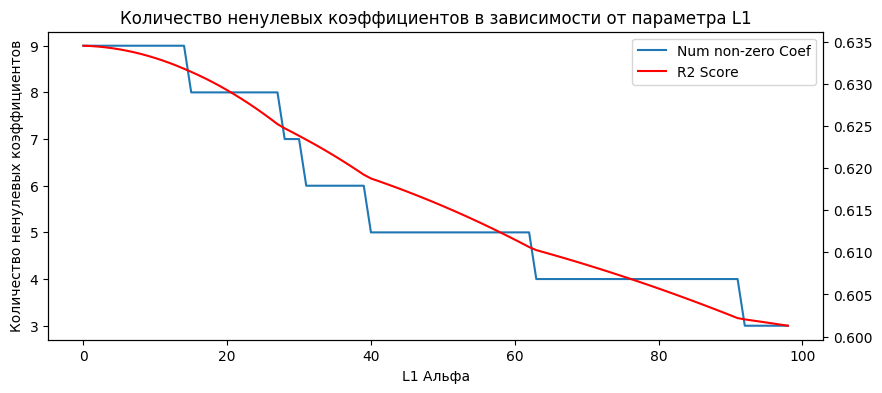

In [ ]:
coeff = []
scores = []
for alpha in range(1, 100):
  lassoModel = ElasticNet(alpha=alpha, l1_ratio=1)
  lassoModel.fit(X_factors, Y)
  coeff.append(lassoModel.coef_)
  scores.append(lassoModel.score(X_factors, Y))

lassoDf = pd.DataFrame(coeff, columns = X_factors.columns)
lassoDf['Num Above Zero'] = lassoDf.apply(lambda row: (np.abs(row) > 0).sum(), axis='columns')
lassoDf['score'] = scores

f, ax = plt.subplots(figsize=(10,4))
ax.plot(lassoDf['Num Above Zero'], label = 'Num non-zero Coef')
ax.set_title('Количество ненулевых коэффициентов в зависимости от параметра L1')
ax.set_xlabel('L1 Альфа')
ax.set_ylabel('Количество ненулевых коэффициентов')
ax2 = ax.twinx()
ax2.plot(lassoDf['score'], color='red', label='R2 Score')


lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

Из графика можно сделать вывод, что с увеличением значения alpha количество ненулевых коэффициентов уменьшается, что означает, что некоторые признаки были признаны моделью нерелевантными. В то же время показатель R2 также уменьшается, что свидетельствует о снижении эффективности модели на обучающих данных. 

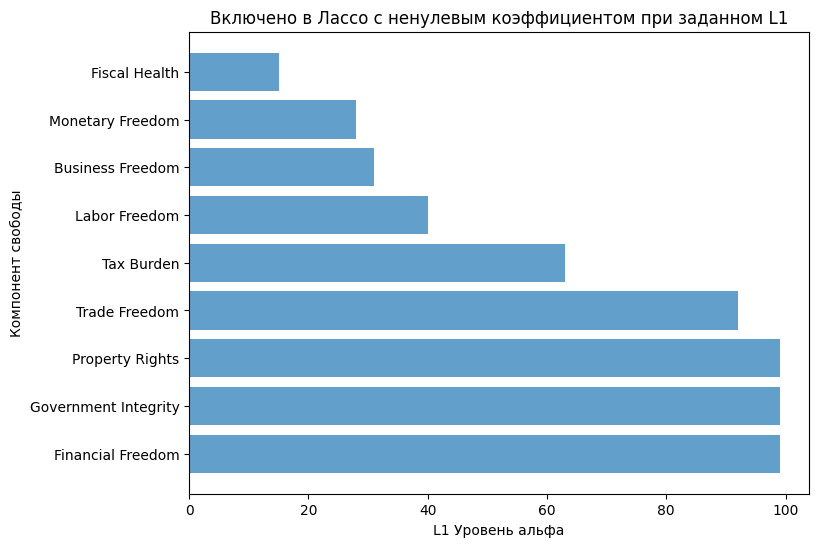

In [ ]:
aboveZeroDf = lassoDf[X_factors.columns] ** 2 > 0
lengthInModel = aboveZeroDf.sum(axis="index").sort_values()


f, ax = plt.subplots(figsize=(8, 6))
yRange = range(9, 0, -1)
ax.barh(yRange, lengthInModel, alpha=0.7)
ax.set_title("Включено в Лассо с ненулевым коэффициентом при заданном L1")
ax.set_ylabel("Компонент свободы")
ax.set_xlabel("L1 Уровень альфа")
ax.set_yticks(yRange)
ax.set_yticklabels(lengthInModel.index)
plt.show()

Диаграмма показывает, как изменяется количество характеристик с ненулевыми коэффициентами при увеличении значения альфа.

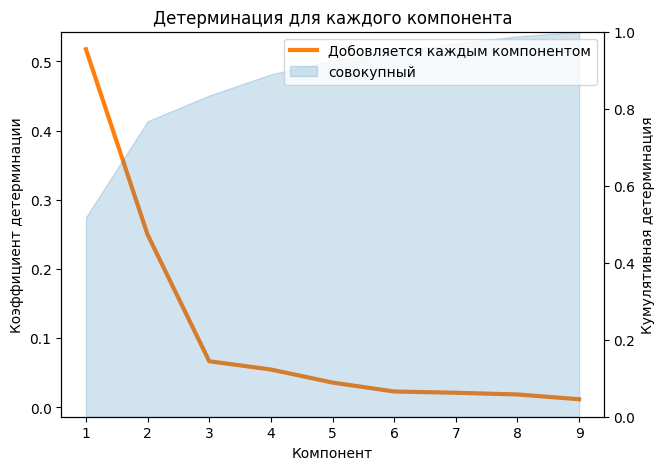

In [ ]:
pca = PCA(n_components=9)
pca.fit(X_factors)

eachcomponent = pca.explained_variance_ratio_
comulative = np.cumsum(eachcomponent)

f, ax = plt.subplots(figsize=(7,5))

ax2 = ax.twinx()
ax2.fill_between(range(1,10), comulative, 0, label='совокупный', color='tab:blue', alpha=0.2)
ax2.set_ylabel('Кумулятивная детерминация')
ax2.set_ylim(0, 1)

ax.plot(range(1,10), eachcomponent, color='tab:orange', label='Добовляется каждым компонентом', linewidth=3)
ax.set_ylabel('Коэффициент детерминации')
ax.set_xlabel('Компонент')
ax.set_xticks(range(1, 10))
ax.set_title('Детерминация для каждого компонента')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

График показывает вклад каждого компонента в объясненную дисперсию, а также кумулятивную объясненную дисперсию по мере добавления новых компонентов.

Оранжевая линия на графике представляет коэффициент детерминации, вносимый каждым компонентом, а заштрихованная синим цветом область представляет кумулятивный коэффициент детерминации по мере добавления новых компонентов. 

In [ ]:
x_transformed = pd.DataFrame(pca.transform(X_factors))
print(x_transformed.corrwith(Y))

0   -0.692175
1    0.339887
2   -0.035790
3   -0.021684
4   -0.157387
5    0.083736
6    0.039219
7   -0.067244
8    0.017156
dtype: float64


Мы видим, что первый компонент имеет относительно сильную отрицательную корреляцию с целевой переменной (-0,692), что указывает на то, что он содержит важную информацию для прогнозирования целевой переменной. Второй компонент имеет умеренную положительную корреляцию (0,34), в то время как другие компоненты имеют слабую или незначительную корреляцию с целевой переменной.

In [ ]:
x_transformed = sm.add_constant(x_transformed)
model = sm.OLS(Y, x_transformed).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     sqrt of GDP per Capita   R-squared:                       0.635
Model:                                OLS   Adj. R-squared:                  0.614
Method:                     Least Squares   F-statistic:                     31.44
Date:                    Mon, 15 May 2023   Prob (F-statistic):           2.28e-31
Time:                            05:26:50   Log-Likelihood:                -896.12
No. Observations:                     173   AIC:                             1812.
Df Residuals:                         163   BIC:                             1844.
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

Исходя из итоговых результатов, модель имеет значение R-квадрат 0,635, что указывает на то, что 63,5% дисперсии целевой переменной может быть объяснено преобразованными данными. F-статистика значима при очень низком p-значении (2,28e-31), что указывает на значимость модели в целом. Некоторые из преобразованных характеристик, а именно 0, 1, 4 и 5, имеют статистически значимые коэффициенты на 5% уровне значимости, что указывает на то, что они являются важными предикторами целевой переменной. Другие преобразованные признаки не имеют статистически значимых коэффициентов, что указывает на то, что они не являются важными предикторами целевой переменной.

In [ ]:
x_transformed_selected = x_transformed[[0, 1, 4, 5]]
x_transformed_selected = sm.add_constant(x_transformed_selected)
model = sm.OLS(Y, x_transformed_selected).fit()
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     sqrt of GDP per Capita   R-squared:                       0.626
Model:                                OLS   Adj. R-squared:                  0.618
Method:                     Least Squares   F-statistic:                     70.42
Date:                    Mon, 15 May 2023   Prob (F-statistic):           6.46e-35
Time:                            05:26:50   Log-Likelihood:                -898.01
No. Observations:                     173   AIC:                             1806.
Df Residuals:                         168   BIC:                             1822.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

Из результатов этого регрессионного анализа можно сделать несколько выводов:

Значение R-квадрат модели составляет 0,626, что означает, что около 62,6% вариации зависимой переменной может быть объяснено независимыми переменными, включенными в модель.

Скорректированное значение R-квадрат равно 0,618, которое учитывает количество независимых переменных в модели и является более точным показателем соответствия модели.

Значение F-статистики составляет 70,42, а соответствующее p-значение очень мало (6,46e-35), что указывает на статистическую значимость модели в целом.

In [ ]:
x_transformed_selected_no_const = x_transformed_selected.drop(['const'], axis='columns')
print(x_transformed_selected_no_const.corr().round(3))

     0    1    4    5
0  1.0  0.0 -0.0 -0.0
1  0.0  1.0 -0.0 -0.0
4 -0.0 -0.0  1.0  0.0
5 -0.0 -0.0  0.0  1.0


Все значения на диагонали равны 1,0, так как каждая переменная идеально коррелирует сама с собой. Значения вне диагонали близки к 0, что указывает на слабую или нулевую корреляцию между переменными.

In [ ]:
all_x = pd.concat([X_factors, x_transformed_selected_no_const], axis='columns')

corrmatrix = all_x.corr()
selectCols = corrmatrix[[0, 1, 4, 5]]
selectRows = selectCols.loc[X_factors.columns]

print(selectRows.round(2))

                         0     1     4     5
Property Rights      -0.87  0.40 -0.09 -0.03
Government Integrity -0.82  0.41 -0.06  0.24
Tax Burden            0.22 -0.07 -0.44  0.27
Fiscal Health        -0.71 -0.71  0.01  0.01
Business Freedom     -0.77  0.35 -0.25 -0.33
Labor Freedom        -0.41  0.28  0.46 -0.02
Monetary Freedom     -0.53  0.17  0.23 -0.14
Trade Freedom        -0.69  0.28 -0.19 -0.20
Financial Freedom    -0.74  0.38  0.15  0.07


Из результатов видно, что переменные имеют слабую или умеренную корреляцию, с коэффициентами корреляции от -0,87 до 0,46. В частности, мы видим, что самая сильная отрицательная корреляция наблюдается между переменной "Права собственности" и переменными "Честность правительства" и "Свобода бизнеса", а самая сильная положительная корреляция между переменной "Фискальное здоровье" и переменной "Свобода труда".

Text(0.5, 1.0, 'Компоненты / Факторы Корреляции')

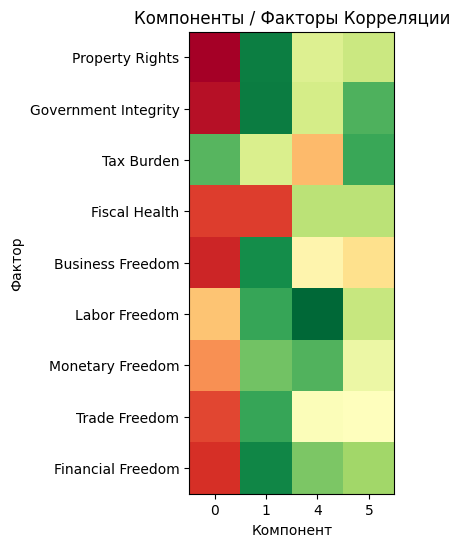

In [ ]:
f, ax = plt.subplots(figsize=(4,6))
ax.imshow(selectRows, cmap='RdYlGn')
yRange = range(len(selectRows.index))
xRange = range(len(selectRows.columns))
ax.set_yticks(yRange)
ax.set_yticklabels(selectRows.index)
ax.set_xticks(xRange)
ax.set_xticklabels(selectRows.columns)
ax.set_xlabel('Компонент')
ax.set_ylabel('Фактор')
ax.set_title('Компоненты / Факторы Корреляции')

График обеспечивает полезную визуализацию взаимосвязей между переменными.

# Вывод

Простая модель дает прямолинейную интерпретацию взаимосвязи между переменной "2019 Score" и квадратным корнем из "GDP per Capita (PPP)". Однако она не учитывает мультиколлинеарность, что может привести к завышенным стандартным ошибкам и неустойчивым оценкам коэффициентов. Это ограничение может повлиять на точность прогнозов и надежность модели.

Модель Лассо, с другой стороны, решает проблему мультиколлинеарности путем введения штрафного члена, который поощряет разреженность в оценках коэффициентов. Она выполняет отбор признаков, уменьшая менее важные предикторы до нуля, фактически удаляя их из модели. Это приводит к более сжатой модели с меньшим количеством предикторов, что может улучшить интерпретируемость модели и потенциально повысить ее прогностическую эффективность, сосредоточившись на наиболее значимых переменных.

Модель PCA, хотя и не решает проблему мультиколлинеарности в явном виде, косвенно помогает решить эту проблему путем снижения размерности данных. Она преобразует исходные переменные в новый набор некоррелированных компонентов, называемых главными компонентами. Улавливая максимальное количество вариаций в данных с помощью меньшего числа компонентов, модель РСА упрощает модель и уменьшает влияние мультиколлинеарности. Кроме того, модель РСА дает представление о наиболее влиятельных компонентах, что может помочь в понимании основных закономерностей и структуры данных.

В заключение следует отметить, что простая модель - это базовый подход, который может дать первоначальное представление о взаимосвязи между переменными. Однако модели Lasso и PCA предлагают более продвинутые методы для решения проблемы мультиколлинеарности и обеспечивают более надежные и интерпретируемые результаты. Модель Лассо выбирает наиболее значимые предикторы, а модель РСА фиксирует наиболее влиятельные компоненты. Выбор модели зависит от конкретных целей анализа, желаемого компромисса между простотой и точностью прогнозирования, а также необходимости решения проблемы мультиколлинеарности в данных.